## Artificial Intelligence II - Final Project

Michel Berden, mberden@uwo.ca

Ana Leopold, aleopol2@uwo.ca

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [2]:
# Loading the data
df=pd.read_csv(r"./user_behavior_dataset.csv")
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


## Data Visualization

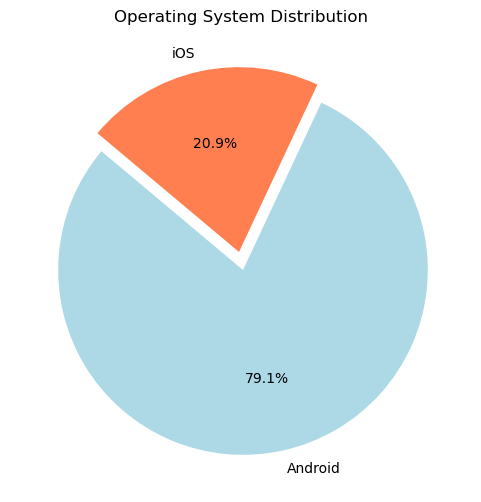

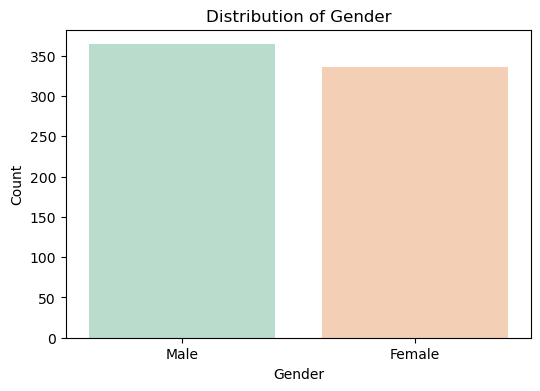

In [3]:
# Operating System Distribution
plt.figure(figsize=(6, 6))
df['Operating System'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'coral'], startangle=140, explode=[0.05, 0.05])
plt.title('Operating System Distribution')
plt.ylabel('')
plt.show()

# Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='Pastel2')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


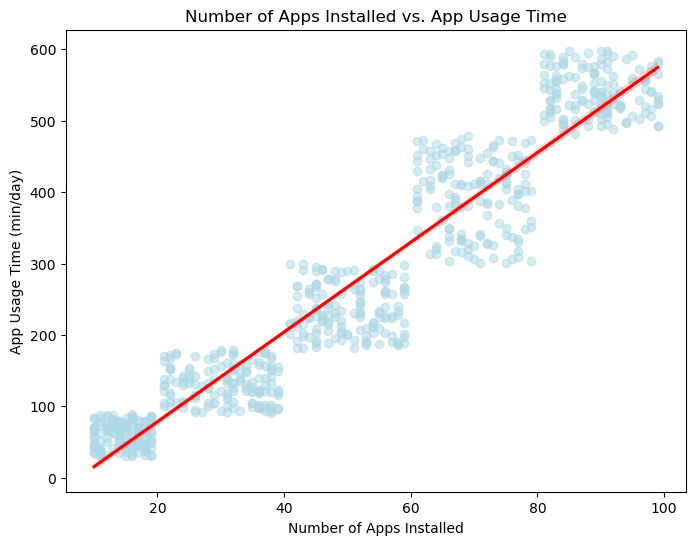

In [4]:
# Correlation between Battery Drain and App Usage Time
plt.figure(figsize=(8, 6))
sns.regplot(x='Number of Apps Installed', y='App Usage Time (min/day)', data=df,  scatter_kws={'alpha': 0.5, 'color': 'lightblue'}, line_kws={'color':'red'})
plt.title('Number of Apps Installed vs. App Usage Time')
plt.xlabel('Number of Apps Installed')
plt.ylabel('App Usage Time (min/day)')
plt.show()

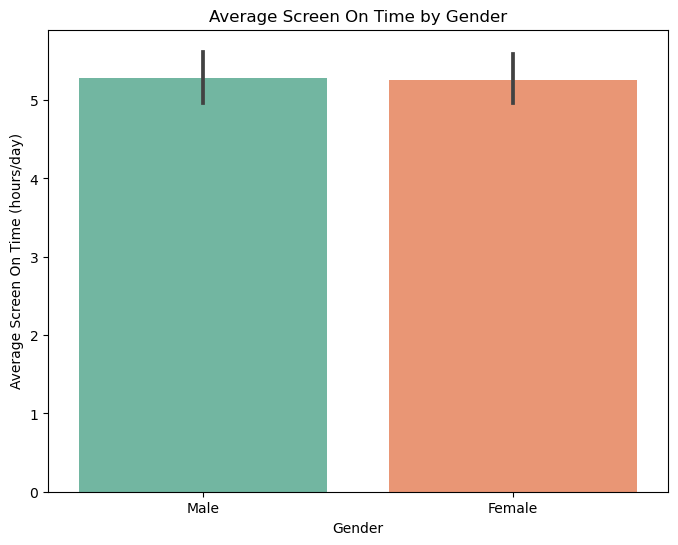

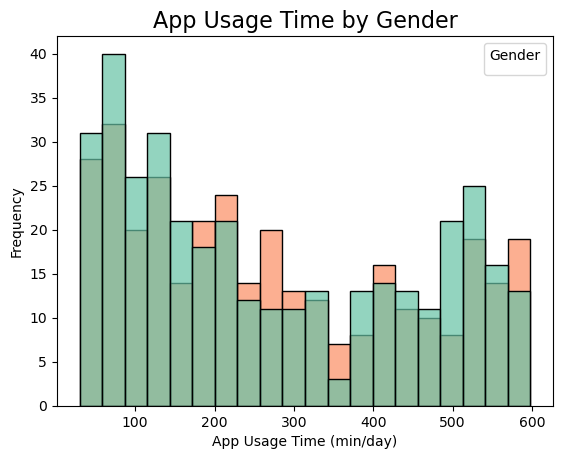

In [5]:
# App Usage Time and Screen-On Time by Genders

plt.figure(figsize=(8, 6))
sns.barplot(x='Gender', y='Screen On Time (hours/day)', data=df , palette='Set2')
plt.title('Average Screen On Time by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Screen On Time (hours/day)')
plt.show()

# Single plot with gender-based distinction
sns.histplot(
    data=df,
    x='App Usage Time (min/day)',
    hue='Gender',
    bins=20,
    kde=False,
    palette='Set2',
    alpha=0.7
)

plt.title('App Usage Time by Gender', fontsize=16)
plt.xlabel('App Usage Time (min/day)')
plt.ylabel('Frequency')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Female', 'Male'], title='Gender')
plt.show()


## Data Preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder

# Does not have an impact, so it is removed
df=df.drop(columns=['User ID'])

#Encoding categorical variables
# df = pd.get_dummies(df, columns=['Device Model', 'Operating System'], drop_first=True)
# label_encoder = LabelEncoder()
# df['Gender'] = label_encoder.fit_transform(df['Gender'])


le=LabelEncoder()    #Encoding categorical values
for col in df.columns[df.dtypes=='object']:
    df[col]=le.fit_transform(df[col])

df['Data_consumption_for_app']=df['App Usage Time (min/day)']/df['Data Usage (MB/day)']
df['App_Usage_Prop']=df['App Usage Time (min/day)']/(df['Screen On Time (hours/day)']*60)


## Decision Tree

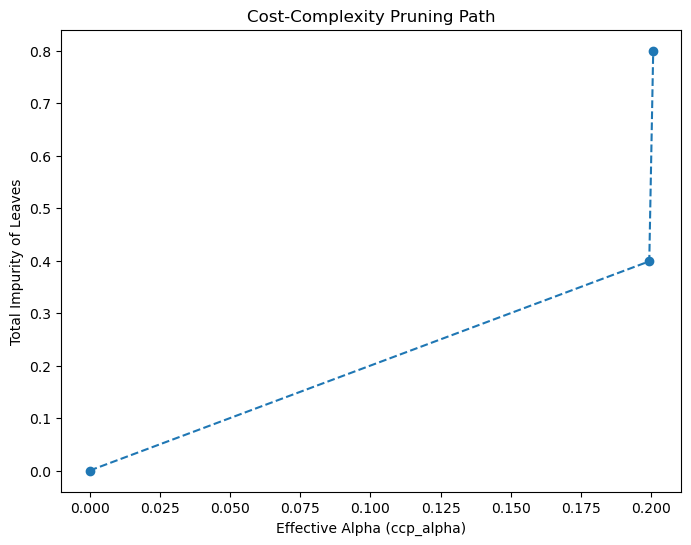

0.0


In [8]:
# Cost-Complexity Pruning

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RandomizedSearchCV

# Splitting data

x=df.drop(columns='User Behavior Class')
y=df['User Behavior Class']
x_t,x_te,y_t,y_te=train_test_split(x,y,test_size=0.25,random_state=20)

# Step 1: Initialize Decision Tree and calculate pruning path
dt = DecisionTreeClassifier(random_state=42)
path = dt.cost_complexity_pruning_path(x_t, y_t)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Visualize the pruning process
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, impurities, marker='o', linestyle='--')
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Total Impurity of Leaves")
plt.title("Cost-Complexity Pruning Path")
plt.show()

# Step 2: Randomized Search for pruning parameter
pruning_params = {'ccp_alpha': ccp_alphas}
search = RandomizedSearchCV(
    dt,
    param_distributions=pruning_params,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    n_iter=3,
    random_state=20
) 
search.fit(x_t, y_t)
best_alpha = search.best_params_['ccp_alpha']
print(best_alpha)


Best Hyperparameters: {'min_samples_split': 34, 'min_samples_leaf': 33, 'max_depth': 9, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9943033381712626


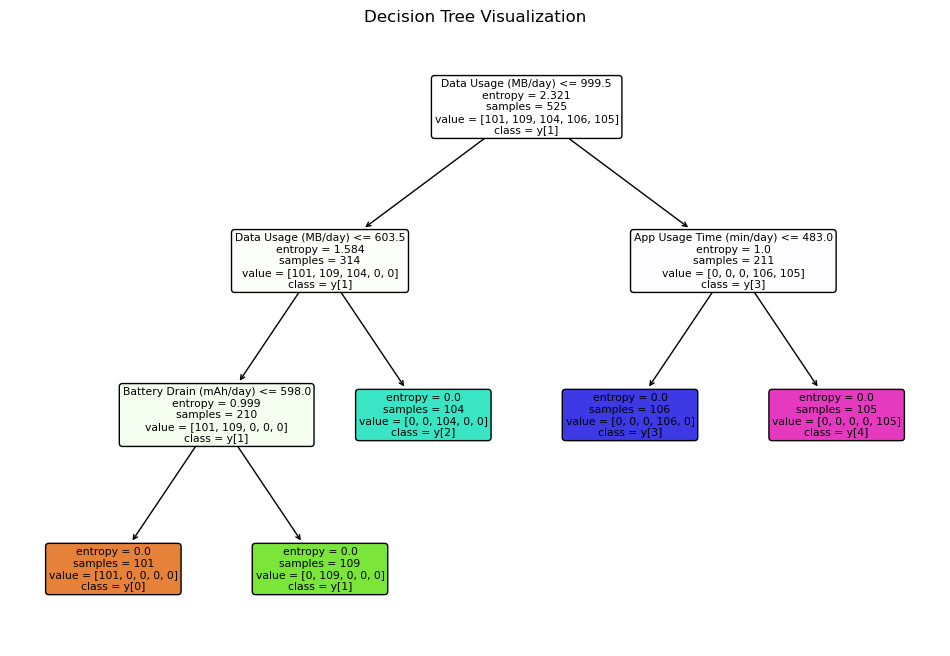

In [9]:
# Step 3: Initialize new Decision Tree with optimal pruning
dt = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)

# Step 4: Randomized Search for additional hyperparameters
hyperparameter_space = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': list(range(2, 41)),
    'min_samples_leaf': list(range(2, 41)),
    'max_depth': list(range(1, 10))
}
search = RandomizedSearchCV(
    dt,
    param_distributions=hyperparameter_space,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    random_state=20
)
search.fit(x_t, y_t)

# Step 5: Final Model Training and Prediction
best_model = search.best_estimator_
train_predictions = best_model.predict(x_t)
test_predictions = best_model.predict(x_te)

print("Best Hyperparameters:", search.best_params_)
print("Best Cross-Validation Score:", search.best_score_)

# Visualize the final Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(
    best_model,
    filled=True,
    feature_names=x_t.columns,
    class_names=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Evaluation based on accuracy. precision, recall, f1-score, and confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("Train Accuracy:", accuracy_score(y_t, train_predictions))
print("Test Accuracy:", accuracy_score(y_te, test_predictions))


# Training Evaluation
train_accuracy = accuracy_score(y_t, train_predictions)
train_precision = precision_score(y_t, train_predictions, average='weighted')
train_recall = recall_score(y_t, train_predictions, average='weighted')
train_f1 = f1_score(y_t, train_predictions, average='weighted')

print("Training Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Test Set Evaluation
test_accuracy = accuracy_score(y_te, test_predictions)
test_precision = precision_score(y_te, test_predictions, average='weighted')
test_recall = recall_score(y_te, test_predictions, average='weighted')
test_f1 = f1_score(y_te, test_predictions, average='weighted')


print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


## Random Forest

In [10]:
# Imports
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint

In [11]:
# Define x and y for random forest
x=df.drop(columns='Battery Drain (mAh/day)')
y=df['Battery Drain (mAh/day)']

#Splitting the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=20)

# Parameter optimization for n_estimators and max_depth with Random Forest Regression
params = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 30)}

rf = RandomForestRegressor()
search = RandomizedSearchCV(rf, param_distributions=params, n_iter=5, cv=5)

search.fit(x_train, y_train)

best_rf = search.best_estimator_
print(best_rf)

# Predict with the best model
y_pred = best_rf.predict(x_test)

# Regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


RandomForestRegressor(max_depth=14, n_estimators=133)
Mean Squared Error: 29867.84739314905
Mean Absolute Error: 144.74773669261685
R-squared: 0.9541386641877966


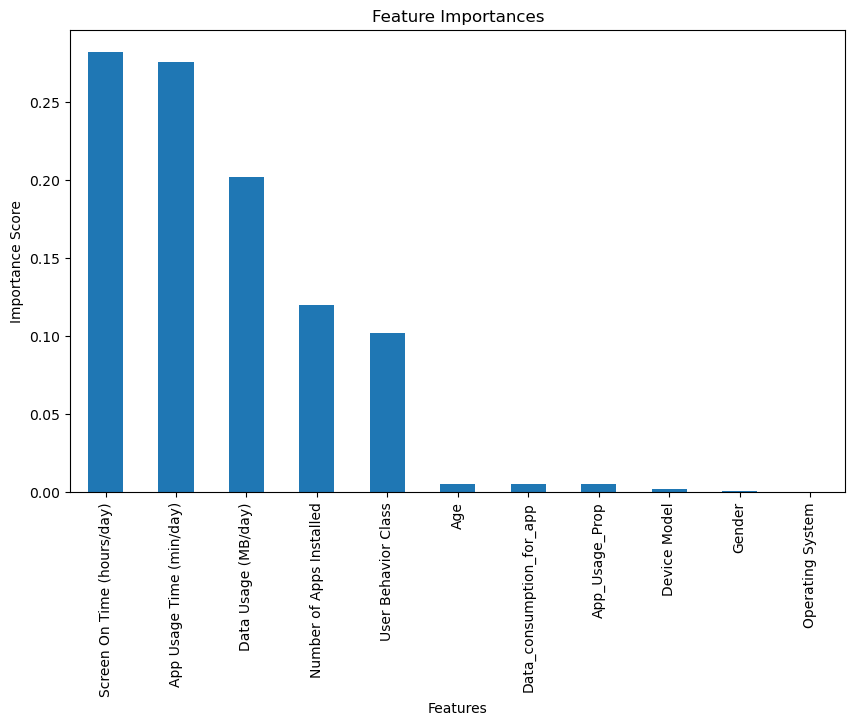

In [12]:
#Create a series containing feature importances
feature_importances = pd.Series(best_rf.feature_importances_, index=x.columns).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
feature_importances.plot.bar()
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()